In [1]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.signal import savgol_filter
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Functions I am adding to parallelize 
import modin.pandas as mpd
import ray
import scipy.signal as signal
import umap

from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier

ray.init(ignore_reinit_error=True, num_cpus=os.cpu_count())
sample_rate=32

2025-10-21 14:13:54,726	INFO worker.py:1718 -- Calling ray.init() again after it has already been called.


In [3]:
# Load label names    
label_names = loadmat('label_names.mat', squeeze_me=True)
activity_names_indexed = label_names['activity_names_indexed']

In [4]:
# Function to extract raw data from files stored in allData folder
def compute_raw_data(dir_name):

    # Load label names    
    label_names = loadmat('label_names.mat', squeeze_me=True)
    activity_names_indexed = label_names['activity_names_indexed']

    # Function to enumerate and assign number labels against different activity names
    string_to_number = {string: number for number, string in enumerate(activity_names_indexed, start=1)}

    # Initialize data arrays
    y_accel_all = []
    y_bar_all = []
    y_bar_ts_all = []
    y_label_all = []
    y_user_all = []
    y_activity_all = []
    column_names_accel = ['ts', 'accel_x', 'accel_y','accel_z']
    y_accel_all_df = pd.DataFrame(columns= column_names_accel)

    # Iterate through accel files
    files = [f for f in os.listdir(dir_name) if f.endswith('-accel.txt')]
    for file_name in files:
        # Extracting activity name, netID from file names
        # for files where there is no IMEI number
        if(file_name[0:4]=='null'):
            substr = dir_name[dir_name.find("allData/")+8:]
            file_name_prefix = file_name[:-(11+len(substr))]
            file_name_common = file_name[:-(10)]
            activity_name = file_name[25:-(11+len(substr))]
        # for files where there is a 15 digit IMEI number  
        else:
            substr = dir_name[dir_name.find("allData/")+8:]
            file_name_prefix = file_name[:-(11+len(substr))]
            file_name_common = file_name[:-(10)]
            activity_name = file_name[36:-(11+len(substr))]

        for activity_index in range(1, len(activity_names_indexed) + 1):
            if len([1 for name in activity_names_indexed if activity_name in name]) > 0:
                break

        # loading acceleration data    
        accel_data = np.loadtxt(os.path.join(dir_name, file_name), delimiter=',')
        ts, accel_x, accel_y, accel_z = accel_data[:, 0], accel_data[:, 1], accel_data[:, 2], accel_data[:, 3]


        # Removing duplicate timestamps
        ts_same = np.where(ts[:-1] == ts[1:])[0]
        accel_data = np.delete(accel_data, ts_same, axis=0)

        # storing data in dataframe
        column_names_accel = ['ts', 'accel_x', 'accel_y','accel_z']
        df_accel_data = pd.DataFrame(accel_data,columns= column_names_accel)

        # sorting data based on timestamp and interpolating data 
        df_accel_data = df_accel_data.sort_values('ts')
        df_accel_data = df_accel_data.interpolate(method='spline', order=2)

        # time to exclude (first and last few seconds are excluded from analysis)
        time_to_exclude = 2
        df_accel_data_trim = df_accel_data.iloc[time_to_exclude*32:-1*time_to_exclude*32]

        # for the same activity and netID, extracting the pressure values as well

        file_name_baro = file_name_common+"-pressure.txt"
        bar_data = np.loadtxt(os.path.join(dir_name, file_name_baro), delimiter=',')
        ts_bar, y_bar = bar_data[:, 0], bar_data[:, 1]

        # Remove duplicate timestamps
        ts_same_bar = np.where(ts_bar[:-1] == ts_bar[1:])[0]
        bar_data = np.delete(bar_data, ts_same_bar, axis=0)

        # checking acceleration and pressure data length
        desired_length = len(df_accel_data)
        bar_data_len = len(bar_data)

        # Interpolate barometer data to match the length of accel_data
        interp_indices = np.linspace(0, bar_data_len - 1, desired_length)
        y_bar_interp = interp1d(np.arange(bar_data_len), bar_data[:, 1], kind='linear', fill_value='extrapolate')
        y_bar_interpolated = y_bar_interp(interp_indices)

        # Smooth interpolated barometer data
        window_size = 4 * 128
        y_bar_smoothed = savgol_filter(y_bar_interpolated, window_size, 1,mode='nearest')

        # Trim data based on time_to_exclude
        start_idx = int(time_to_exclude * 32)
        end_idx = -start_idx if start_idx > 0 else None
        y_bar_trimmed = y_bar_smoothed[start_idx:end_idx]
        
        # if activity is present in list of activities
        if activity_name in activity_names_indexed:

            y_label = np.full(len(y_bar_trimmed), string_to_number[activity_name])
            y_activity = np.full(len(y_bar_trimmed), activity_name)
            y_user = np.full(len(y_bar_trimmed), substr)

            # only sets of 128 data is processed
            multiple_of_128 = 128 * (len(y_label) // 128)
            y_bar_f = y_bar_trimmed[:multiple_of_128]
            y_label_f = y_label[:multiple_of_128]
            y_user_f = y_user[:multiple_of_128]
            y_activity_f = y_activity[:multiple_of_128]

            y_accel_f = df_accel_data_trim.iloc[:multiple_of_128, :]

            # Concatenate results into new arrays
            y_accel_all_df = pd.concat([y_accel_all_df, y_accel_f],ignore_index=True)
            y_label_all = np.concatenate((y_label_all, y_label_f))
            y_user_all = np.concatenate((y_user_all, y_user_f))
            y_activity_all = np.concatenate((y_activity_all, y_activity_f))
            y_bar_all = np.concatenate((y_bar_all, y_bar_f))

    # add pressure,label,user and activity values into dataframe  
    y_accel_all_df['y_bar'] = y_bar_all
    y_accel_all_df['label'] = y_label_all
    y_accel_all_df['user'] = y_user_all
    y_accel_all_df['activity'] = y_activity_all

    # returning final dataframe
    return y_accel_all_df

TO DO 

Set your NetID below.

In [5]:
# Set your netid
my_netid = "ahs264"

In [6]:
# Location of data directory
data_dir = os.path.join(os.getcwd(), 'allData')

In [7]:
col_names_raw = ['ts', 'accel_x', 'accel_y','accel_z','y_bar','label','user','activity']
df_raw = pd.DataFrame(columns= col_names_raw)

In [8]:
# Extracting all raw data by iterating through the files

for data_dir_name in os.listdir(data_dir):
    # Goes through all of the directories representing all imei addresses
    if os.path.isdir(os.path.join(data_dir, data_dir_name)) and data_dir_name[0] != '.':

        print(f'Processing directory {data_dir_name}')
        # Compute raw data
        dir_path = os.path.join(data_dir, data_dir_name)
        df_raw_temp = compute_raw_data(dir_path)

        df_raw_temp = df_raw_temp.sort_values(by = ['label', 'ts'], ignore_index=True)
        df_raw = pd.concat([df_raw, df_raw_temp],ignore_index=True)


Processing directory ahs264
Processing directory cyt25
Processing directory xl549
Processing directory jl2855
Processing directory xz278
Processing directory johnsweeney
Processing directory mmill
Processing directory mrossman
Processing directory sutreja
Processing directory jao57
Processing directory aaleksanyan
Processing directory aks249
Processing directory mmb289
Processing directory av452
Processing directory sp2333
Processing directory nbw32
Processing directory nk428
Processing directory mlc299
Processing directory cgp46
Processing directory wh298
Processing directory jps394
Processing directory bl4521
Processing directory ktc36


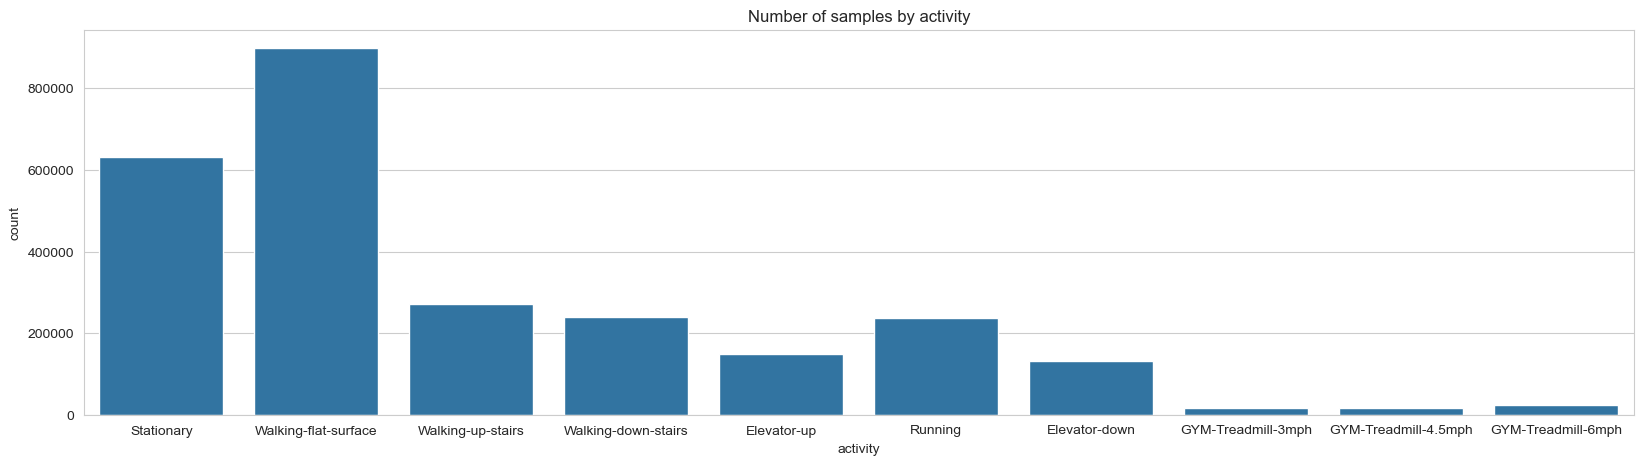

In [9]:
# Distribution of activities 
sns.set_style("whitegrid")
plt.figure(figsize = (20, 5))
sns.countplot(x = "activity", data = df_raw)
plt.title("Number of samples by activity")
plt.show()

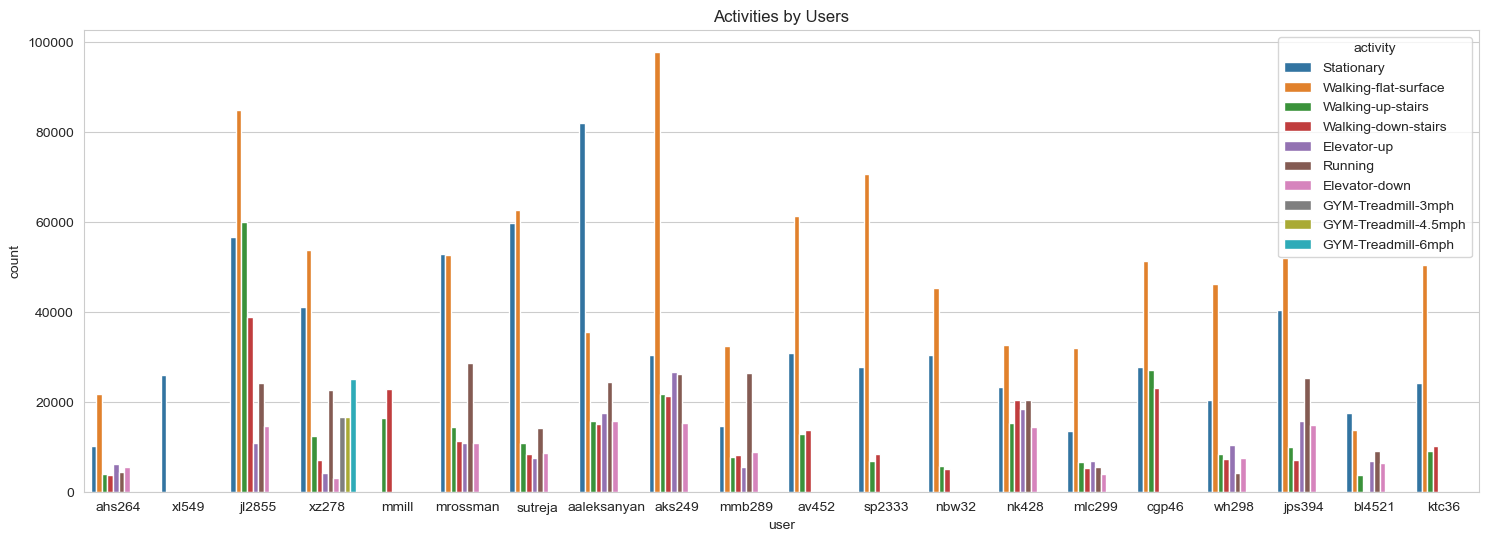

In [10]:
# Distribution of activities among different users

plt.figure(figsize = (18, 6))
sns.countplot(x = "user", hue = "activity", data = df_raw)
plt.title("Activities by Users")
plt.show()

In [11]:
df_raw

,ts,accel_x,accel_y,accel_z,y_bar,label,user,activity
0,1.424731e+12,-0.002694,-0.285007,9.264983,998.346950,1.0,ahs264,Stationary
1,1.424731e+12,-0.053289,-0.001946,9.371412,998.346655,1.0,ahs264,Stationary
2,1.424731e+12,0.084125,-0.322130,9.236543,998.346356,1.0,ahs264,Stationary
3,1.424731e+12,0.316143,-0.003593,9.294771,998.346056,1.0,ahs264,Stationary
4,1.424731e+12,0.015119,-0.283510,9.123378,998.345753,1.0,ahs264,Stationary
...,...,...,...,...,...,...,...,...
2616315,1.457007e+12,-0.229157,3.002625,9.205399,996.077881,4.0,ktc36,Walking-down-stairs
2616316,1.457007e+12,-0.202972,3.009766,9.179215,996.077861,4.0,ktc36,Walking-down-stairs
2616317,1.457007e+12,-0.122040,2.993103,8.993546,996.077842,4.0,ktc36,Walking-down-stairs
2616318,1.457007e+12,-0.148224,2.957397,8.874527,996.077822,4.0,ktc36,Walking-down-stairs


In [12]:
# splitting train data and test data 
df_train = df_raw[df_raw['user'] != my_netid]
df_test = df_raw[df_raw['user'] == my_netid]

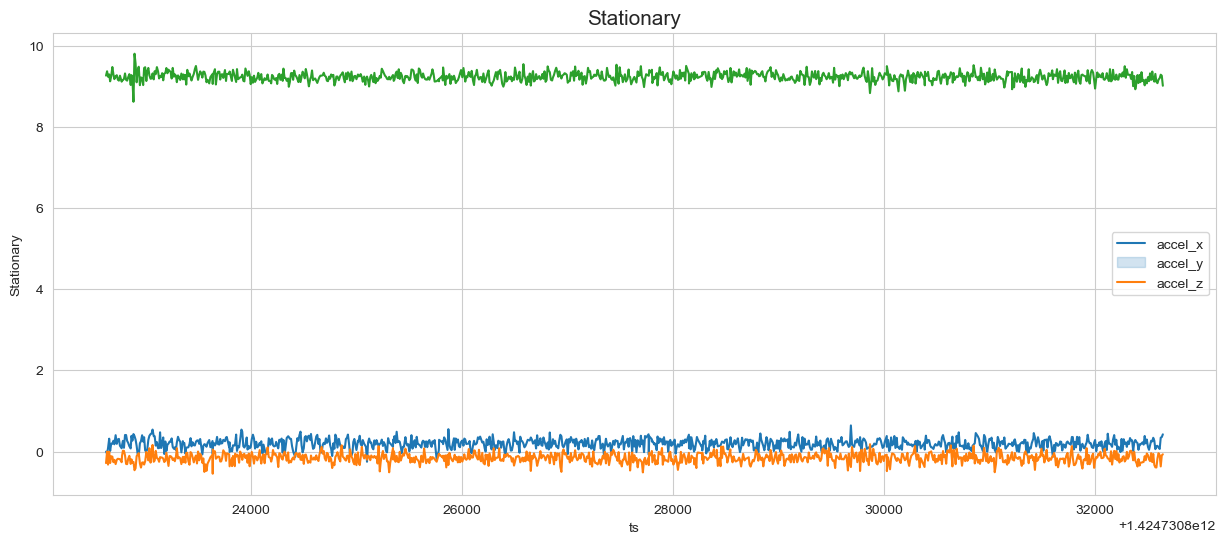

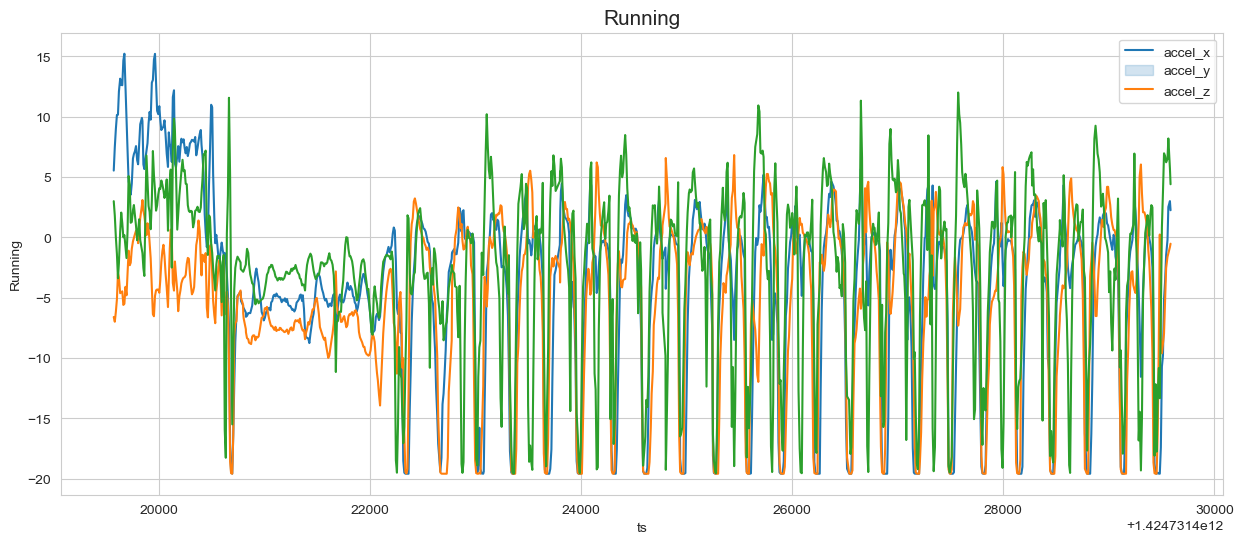

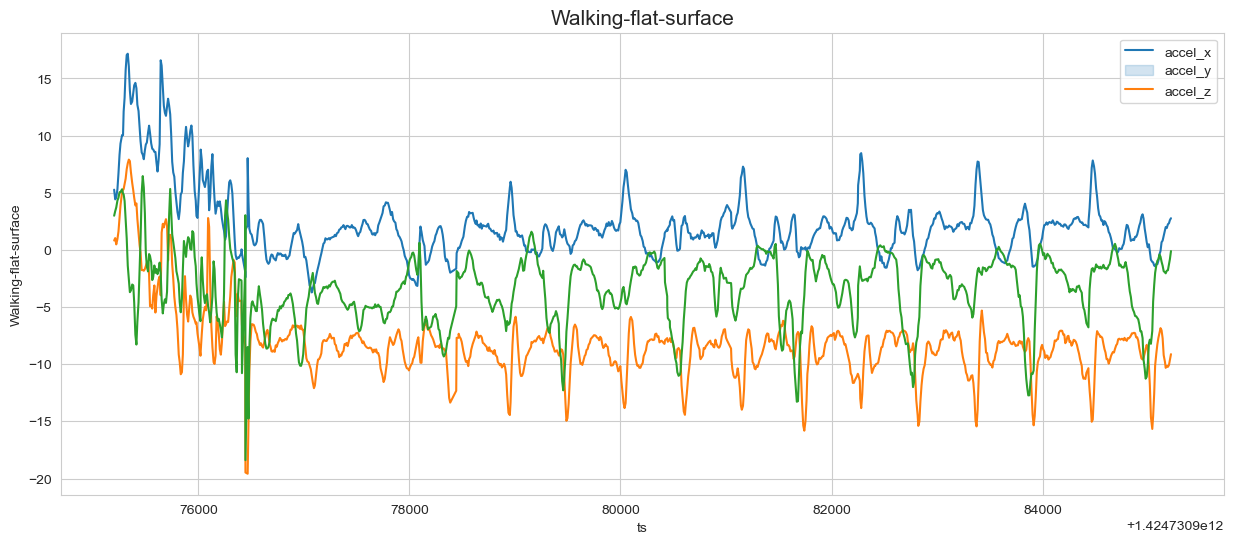

In [13]:
# Visual representation of raw data
# Note how the magnitudes and signal varies for each activity

for i in ["Stationary", "Running", "Walking-flat-surface"]:
    data_x = df_raw[(df_raw["user"] == my_netid) & (df_raw["activity"] == i)][:1000]
    plt.figure(figsize = (15, 6))
    sns.lineplot(y = "accel_x", x = "ts", data = data_x)
    sns.lineplot(y = "accel_y", x = "ts", data = data_x)
    sns.lineplot(y = "accel_z", x = "ts", data = data_x)
    plt.legend(["accel_x", "accel_y", "accel_z"])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

TO DO
 
Do you see any interesting trends while observing signals from different activities (like walking, running stationary) ? Explain what you see. 
Can you think of any specific feature that might help us to differentiate among different activities? You will write a paragraph on this.

In [14]:
x_list_train = []
y_list_train = []
z_list_train = []
b_list_train = []
train_labels = []

# TO DO
# Similarly create test list
x_list_test = []
y_list_test = []
z_list_test = []
b_list_test = []
test_labels = []


# Setting window size of 100 datapoints with an overlap of 50%
window_size = 100
step_size = 50

TO DO

You will extract features from the accelerometer magnitude and barometric pressure time series data. The windowing will be done by a sliding window where the length of the window will be 100 data points with an overlap of 50%. 

In [15]:
# creating overlaping windows of size 100
# Train windows
for i in range(0, df_train.shape[0] - window_size, step_size):
    window = df_train.iloc[i:i + window_size]
    x_list_train.append(window['accel_x'].values)
    y_list_train.append(window['accel_y'].values)
    z_list_train.append(window['accel_z'].values)
    b_list_train.append(window['y_bar'].values)
    train_labels.append(stats.mode(window['label'], keepdims=True)[0][0])
train_labels
   

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [16]:
# creating overlaping windows of size 100
# Test windows
for i in range(0, df_test.shape[0] - window_size, step_size):
    window = df_test.iloc[i:i + window_size]
    x_list_test.append(window['accel_x'].values)
    y_list_test.append(window['accel_y'].values)
    z_list_test.append(window['accel_z'].values)
    b_list_test.append(window['y_bar'].values)
    test_labels.append(stats.mode(window['label'], keepdims=True)[0][0])
test_labels

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

TO DO

Compute Different Time Domain features

In [17]:
# Computing Time Domain Features
def rms(f):
    """Compute Root Mean Square of a signal."""
    return np.sqrt(np.mean(f**2))

@ray.remote
def compute_time_features(x, y, z, b, label):
    """Compute time-domain features for one window."""
    std_x, std_y, std_z, std_b = np.std(x), np.std(y), np.std(z), np.std(b)
    mean_x, mean_y, mean_z, mean_b = np.mean(x), np.mean(y), np.mean(z), np.mean(b)
    rms_x, rms_y, rms_z, rms_b = (rms(x), rms(y), rms(z), rms(b))
    range_x, range_y, range_z, range_b = np.ptp(x), np.ptp(y), np.ptp(z), np.ptp(b)
    skew_x, skew_y, skew_z, skew_b = skew(x), skew(y), skew(z), skew(b)
    kurt_x, kurt_y, kurt_z, kurt_b = kurtosis(x), kurtosis(y), kurtosis(z), kurtosis(b)

    # Magnitude-based features (overall intensity)
    mag = np.sqrt(x**2 + y**2 + z**2)
    std_mag = np.std(mag)
    mean_mag = np.mean(mag)
    rms_mag = np.sqrt(np.mean(mag**2))
    range_mag = np.ptp(mag)

    dict_features = {
                        "label": label,
                        # Acceleration features
                        "std_x": std_x, "std_y": std_y, "std_z": std_z, # Standard deviation axes
                        "mean_x": mean_x, "mean_y": mean_y, "mean_z": mean_z, # Mean axes
                        "rms_x": rms_x, "rms_y": rms_y, "rms_z": rms_z, # RMS axes
                        "range_x": range_x, "range_y": range_y, "range_z": range_z, # Range axes
                        "skew_x": skew_x, "skew_y": skew_y, "skew_z": skew_z, # Skewness axes
                        "kurt_x": kurt_x, "kurt_y": kurt_y, "kurt_z": kurt_z, # Kurtosis axes
                        # Magnitude
                        "std_mag": std_mag, 
                        "mean_mag": mean_mag, 
                        "rms_mag": rms_mag, 
                        "range_mag": range_mag,
                        # Barometer
                        "std_b": std_b, 
                        "mean_b": mean_b, 
                        "rms_b": rms_b, 
                        "range_b": range_b,
                        "skew_b": skew_b, 
                        "kurt_b": kurt_b,
    }
    return dict_features

# Dispatch feature extraction to Ray workers
lst_zip = zip(x_list_train, y_list_train, z_list_train, b_list_train, train_labels)
lst_time_features_train = [
                            compute_time_features.remote(x, y, z, b, label)
                            for x, y, z, b, label in lst_zip
]

# Collect results from all workers
results = ray.get(lst_time_features_train)
lst_time_features_test = [
                            compute_time_features.remote(x, y, z, b, label)
                            for x, y, z, b, label in zip(x_list_test, y_list_test, z_list_test, b_list_test, test_labels)
]


TO DO

Compute Different Frequency Domain Features


In case there are NaN values in features extracted, extrapolate from neighbouring values.(Like mean of above and below value)

In [18]:
# While computing PSD features, you can use the below sampling rate. You can use signal.welch function to compute the features.
# Computing Frequency domain features
# Global sampling rate (Hz)
sample_rate = 32

# Helper function (no nesting)
def spectral_entropy(psd):
    """Compute spectral entropy from a power spectral density array."""
    total_power = np.sum(psd)
    if total_power <= 0:
        return 0.0
    psd_norm = psd / total_power
    return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))

# Ray function to compute PSD-based features
@ray.remote
def compute_frequency_features(x, y, z, b, label, fs=sample_rate):
    """Compute frequency-domain features (Welch PSD + entropy) for one window."""

    # Welch PSD for each signal
    f_x, Pxx = signal.welch(x, fs=fs, nperseg=min(256, len(x)))
    f_y, Pyy = signal.welch(y, fs=fs, nperseg=min(256, len(y)))
    f_z, Pzz = signal.welch(z, fs=fs, nperseg=min(256, len(z)))
    f_b, Pbb = signal.welch(b, fs=fs, nperseg=min(256, len(b)))

    # Dominant frequencies (Hz)
    dom_fx = f_x[np.argmax(Pxx)]
    dom_fy = f_y[np.argmax(Pyy)]
    dom_fz = f_z[np.argmax(Pzz)]
    dom_fb = f_b[np.argmax(Pbb)]

    # Spectral energies (area under PSD)
    energy_x = np.trapz(Pxx, f_x)
    energy_y = np.trapz(Pyy, f_y)
    energy_z = np.trapz(Pzz, f_z)
    energy_b = np.trapz(Pbb, f_b)

    # Spectral entropies (via helper)
    entropy_x = spectral_entropy(Pxx)
    entropy_y = spectral_entropy(Pyy)
    entropy_z = spectral_entropy(Pzz)
    entropy_b = spectral_entropy(Pbb)

    # Return dictionary of features
    dict_features = {
                        "label": label,
                        "dom_freq_x": dom_fx, "dom_freq_y": dom_fy,
                        "dom_freq_z": dom_fz, "dom_freq_b": dom_fb,
                        "energy_x": energy_x, "energy_y": energy_y,
                        "energy_z": energy_z, "energy_b": energy_b,
                        "entropy_x": entropy_x, "entropy_y": entropy_y,
                        "entropy_z": entropy_z, "entropy_b": entropy_b,
    }
    
    return dict_features

zip_frequency_train = zip(x_list_train, y_list_train, z_list_train, b_list_train, train_labels)
list_frequency_features_train = [
                            compute_frequency_features.remote(x, y, z, b, label)
                            for x, y, z, b, label in zip_frequency_train
]
zip_frequency_test = zip(x_list_test, y_list_test, z_list_test, b_list_test, test_labels)
list_frequency_features_test = [
                                compute_frequency_features.remote(x, y, z, b, label)
                                for x, y, z, b, label in zip_frequency_test
]


In [19]:
time_train  = ray.get(lst_time_features_train)
freq_train  = ray.get(list_frequency_features_train)
time_test   = ray.get(lst_time_features_test)
freq_test   = ray.get(list_frequency_features_test)

# Convert lists to Modin DataFrames
df_time_train = mpd.DataFrame(time_train)
df_freq_train = mpd.DataFrame(freq_train)
df_time_test  = mpd.DataFrame(time_test)
df_freq_test  = mpd.DataFrame(freq_test)

features_train = mpd.concat(
                            [df_time_train.drop(columns=["label"], errors="ignore"),
                            df_freq_train.drop(columns=["label"], errors="ignore")],
                             axis=1
)
features_train["label"] = df_time_train["label"]

features_test = mpd.concat(
                            [df_time_test.drop(columns=["label"], errors="ignore"),
                            df_freq_test.drop(columns=["label"], errors="ignore")],
                            axis=1
)
features_test["label"] = df_time_test["label"]

# Prepare data for modeling 
X_train = features_train.drop(columns=["label"])._to_pandas()
y_train = features_train["label"]._to_pandas()
X_test  = features_test.drop(columns=["label"])._to_pandas()
y_test  = features_test["label"]._to_pandas()

TO DO

Prepare a TSNE plot from the extracted features.See if the plot can differentiate between stationary and moving activity labels. Briefly comment on the same. 

You can use 'from sklearn.manifold import TSNE' package


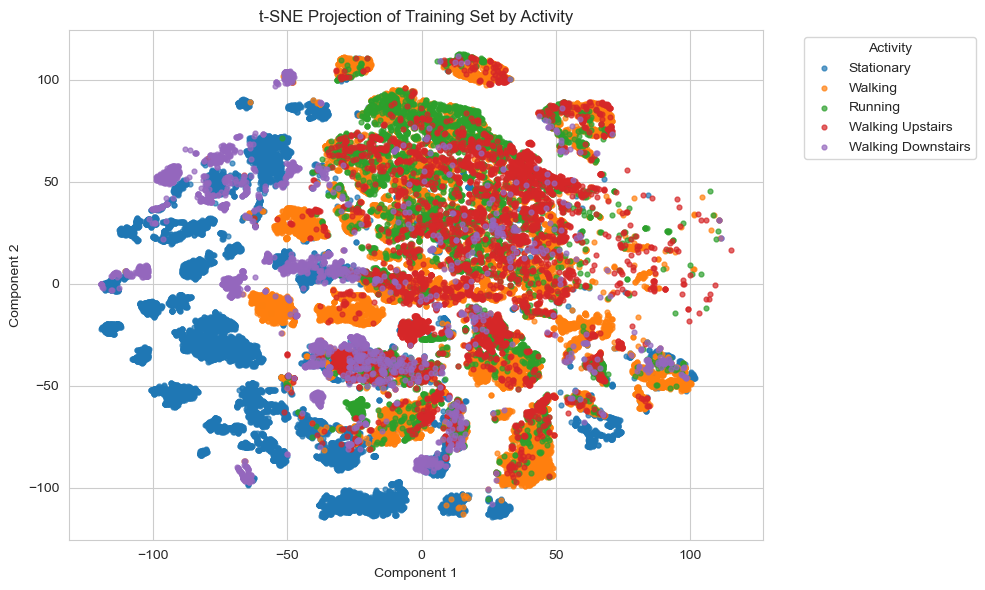

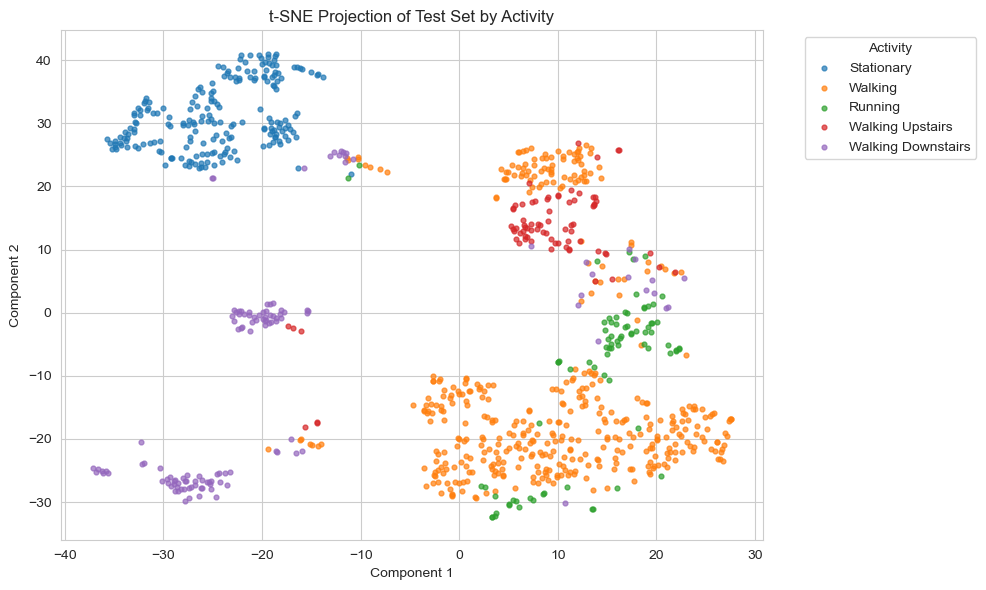

In [29]:
# TSNE
# Handle NaN or infinite values before TSNE
X_train_tsne = X_train.replace([np.inf, -np.inf], np.nan).dropna()
X_test_tsne  = X_test.replace([np.inf, -np.inf], np.nan).dropna()

# Match labels to the cleaned rows
y_train_tsne = y_train.loc[X_train_tsne.index]
y_test_tsne  = y_test.loc[X_test_tsne.index]

# Map numeric labels to readable activity names
activity_map = {
    1.0: "Stationary",
    2.0: "Walking",
    3.0: "Running",
    4.0: "Walking Upstairs",
    5.0: "Walking Downstairs"
}

y_train_named = y_train_tsne.map(activity_map)
y_test_named  = y_test_tsne.map(activity_map)

# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_train_tsne_embedded = tsne.fit_transform(X_train_tsne)
X_test_tsne_embedded  = tsne.fit_transform(X_test_tsne)

# Visualization — Training Set
palette = sns.color_palette("viridis", len(activity_map))
plt.figure(figsize=(10, 6))
for i, (label, name) in enumerate(activity_map.items()):
    mask = y_train_named == name
    plt.scatter(
                X_train_tsne_embedded[mask, 0],
                X_train_tsne_embedded[mask, 1],
                label=name,
                s=12,
                alpha=0.7
    )

plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("t-SNE Projection of Training Set by Activity")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

# Visualization — Test Set
plt.figure(figsize=(10, 6))
for i, (label, name) in enumerate(activity_map.items()):
    mask = y_test_named == name
    plt.scatter(
                X_test_tsne_embedded[mask, 0],
                X_test_tsne_embedded[mask, 1],
                label=name,
                s=12,
                alpha=0.7
    )

plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("t-SNE Projection of Test Set by Activity")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

TO DO

KNN and Random Forest Classification.
Compute the confusion matrix and then compute the precision, recall and F1 score for each activity separately.

compare the performance of these two classifiers and comment on it.


KNN Accuracy: 0.6060

KNN Classification Report:
                    precision    recall  f1-score   support

           Running     0.0645    0.0247    0.0357        81
        Stationary     0.8000    1.0000    0.8889       204
           Walking     0.7579    0.8392    0.7965       429
Walking Downstairs     0.9667    0.2762    0.4296       105
  Walking Upstairs     0.3762    0.5205    0.4368        73

          accuracy                         0.7096       892
         macro avg     0.5931    0.5321    0.5175       892
      weighted avg     0.6979    0.7096    0.6759       892



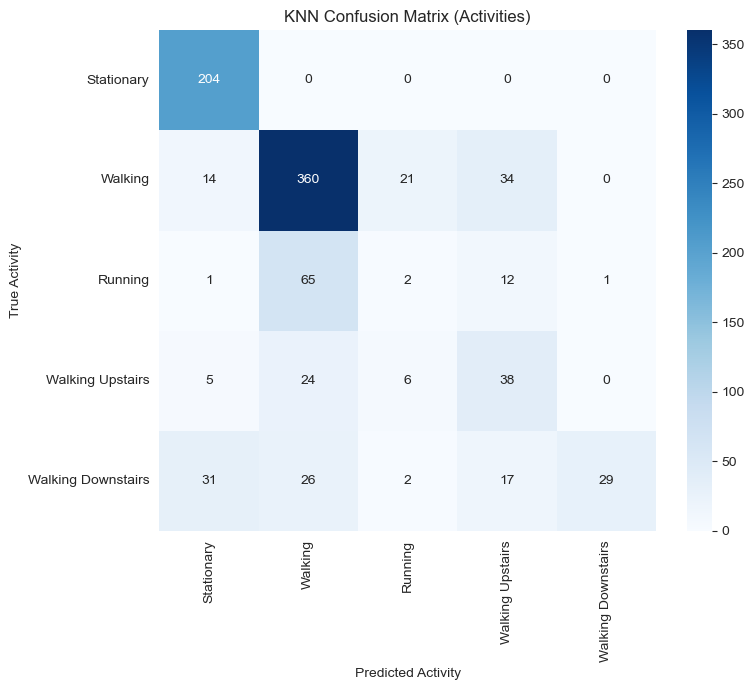

In [33]:
# Map numeric labels to readable activity names
activity_map = {
    1.0: "Stationary",
    2.0: "Walking",
    3.0: "Running",
    4.0: "Walking Upstairs",
    5.0: "Walking Downstairs"
}

# Clean and prepare data for KNN
X_train_knn = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_knn  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Align y to X (ensures same indices and lengths)
y_train_knn = y_train.loc[X_train_knn.index]
y_test_knn  = y_test.loc[X_test_knn.index]

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

# Predict on test data
y_pred_knn = knn.predict(X_test_knn)

# Evaluate KNN performance
acc_knn = accuracy_score(y_test_knn, y_pred_knn)
print(f"\nKNN Accuracy: {acc_knn:.4f}\n")

# Convert numeric to readable labels
y_test_named = y_test_knn.map(activity_map)
y_pred_named = pd.Series(y_pred_knn).map(activity_map)

# Ensure consistent types (remove NaNs and cast to string)
mask = y_test_named.notna() & y_pred_named.notna()
y_test_named = y_test_named[mask].astype(str)
y_pred_named = y_pred_named[mask].astype(str)

print("KNN Classification Report:")
print(classification_report(y_test_named, y_pred_named, digits=4))

# Confusion Matrix
labels_ordered = list(activity_map.values())
conf_mat_knn = confusion_matrix(y_test_named, y_pred_named, labels=labels_ordered)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 7))
sns.heatmap(
    conf_mat_knn,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=labels_ordered,
    yticklabels=labels_ordered
)
plt.title("KNN Confusion Matrix (Activities)")
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.tight_layout()
plt.show()


Random Forest Accuracy: 0.7072

Random Forest Classification Report:
                    precision    recall  f1-score   support

           Running     0.5000    0.4304    0.4626        79
        Stationary     0.9005    0.9851    0.9409       202
           Walking     0.8910    0.8618    0.8762       427
Walking Downstairs     0.9608    0.5326    0.6853        92
  Walking Upstairs     0.5164    0.8400    0.6396        75

          accuracy                         0.8149       875
         macro avg     0.7537    0.7300    0.7209       875
      weighted avg     0.8331    0.8149    0.8134       875



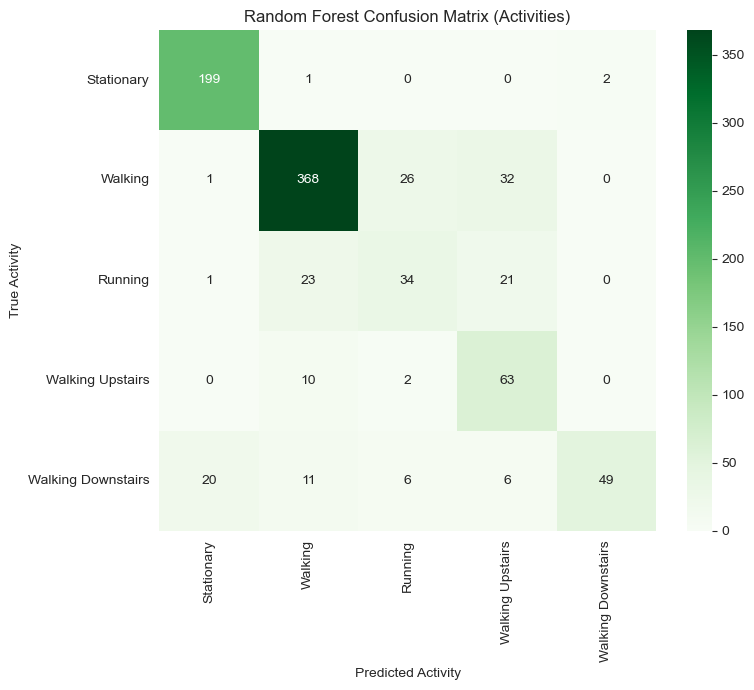

In [34]:
# Clean and prepare data for Random Forest
X_train_rf = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.mean())
X_test_rf  = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.mean())

# Align y to X (ensures same indices and lengths)
y_train_rf = y_train.loc[X_train_rf.index]
y_test_rf  = y_test.loc[X_test_rf.index]

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)

# Predict on test data
y_pred_rf = rf.predict(X_test_rf)

# Evaluate Random Forest performance
acc_rf = accuracy_score(y_test_rf, y_pred_rf)
print(f"\nRandom Forest Accuracy: {acc_rf:.4f}\n")

# Convert numeric to readable labels
y_test_named = y_test_rf.map(activity_map)
y_pred_named = pd.Series(y_pred_rf).map(activity_map)

# Ensure consistent types (remove NaNs and cast to string)
mask = y_test_named.notna() & y_pred_named.notna()
y_test_named = y_test_named[mask].astype(str)
y_pred_named = y_pred_named[mask].astype(str)

print("Random Forest Classification Report:")
print(classification_report(y_test_named, y_pred_named, digits=4))

# Confusion Matrix
labels_ordered = list(activity_map.values())
conf_mat_rf = confusion_matrix(y_test_named, y_pred_named, labels=labels_ordered)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 7))
sns.heatmap(
    conf_mat_rf,
    annot=True,
    fmt='d',
    cmap="Greens",
    xticklabels=labels_ordered,
    yticklabels=labels_ordered
)
plt.title("Random Forest Confusion Matrix (Activities)")
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.tight_layout()
plt.show()

TO DO

Time Domain vs Frequency Domain

Use just time domain and frequency domain features seperately and run the same classifier. Which domain ( frequency domain vs time domain ) is helping you the most in terms of building your activity recognition system ? Comment on it.

In [ ]:
# TD vs FD

TO DO

Cross validation- you will implement Leave One Subject Out Cross Validation . 

For this task, you are free to select any classifier you like.


In [ ]:
# Cross Validation

BONUS POINTS

Try building a basic CNN model and use either the raw time series data or the extracted feature set as input and try to classify the different activities
